# Capstone Machine Learning Algorithm Creation

In [27]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt

In [28]:
database = "group3-DB"
table = "dbo.hcrypto"
user = "group3_user"
password  = "K-qC4SoI_oUvepg"
server = "gen10-data-fundamentals-21-11-sql-server.database.windows.net"

In [29]:
#read table data into a pandas dataframe
conn = pymssql.connect(server, user, password, database)
cursor = conn.cursor()
query = f"SELECT * FROM {table}"
hcr_df = pd.read_sql(query, conn)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [30]:
btc_df = hcr_df[hcr_df['Currency'] == 'BTC']
btc_df = btc_df.drop(columns = 'Currency')
btc_df['Date'] = pd.to_datetime(btc_df['Date'], format='%Y-%m-%d')
btc_df.sort_values('Date', inplace=True)
btc_df.reset_index(drop=True, inplace=True)

In [31]:
btc_df

,Date,Open,High,Low,Close,Volume,Market Cap
0,2020-02-01,9351.71,9464.53,9281.00,9384.61,28578.067354,28578.067354
1,2020-02-02,9384.41,9477.03,9120.00,9331.51,45690.912540,45690.912540
2,2020-02-03,9331.59,9618.79,9234.00,9292.24,50892.133451,50892.133451
3,2020-02-04,9291.35,9350.00,9093.01,9197.02,53308.175266,53308.175266
4,2020-02-05,9197.02,9744.45,9177.22,9612.04,64870.415615,64870.415615
...,...,...,...,...,...,...,...
740,2022-02-10,44372.71,45821.00,43174.01,43495.44,62357.290910,62357.290910
741,2022-02-11,43495.44,43920.00,41938.51,42373.73,44975.168700,44975.168700
742,2022-02-12,42373.73,43079.49,41688.88,42217.87,26556.856810,26556.856810
743,2022-02-13,42217.87,42760.00,41870.00,42053.66,17732.081130,17732.081130


### AR Model Stuff

Create an autoregressive model which uses the High price of Apple stock

Autoregressive (AR) Models create predictions of points by using previous points in the time series. The simplicity of the model lies in the fact that typically only uses the dependent variable to make predictions, and it only has one hyperparameter which controls the number of previous points used in prediction. This hyperparameter is often referred to as the order or lag of the model.

In [32]:
m_df = btc_df.drop(columns=['Date', 'Open', 'Close', 'Low', 'Volume', 'Market Cap'])

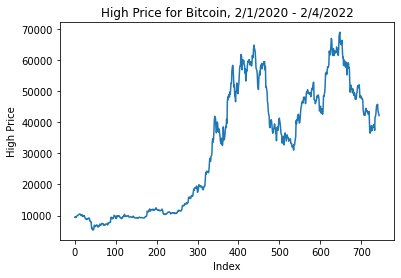

In [33]:
plt.plot(m_df['High'])

plt.ylabel('High Price')
plt.xlabel('Index')
plt.title('High Price for Bitcoin, 2/1/2020 - 2/4/2022')
plt.show()

ADFuller test

This test allows us to determine if there is a unit root in the data which would interfere with our machine learning process.

In [34]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(m_df['High'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -1.2639274081093477,
 'pvalue': 0.6455098213784509,
 'usedlag': 4,
 'nobs': 740,
 'criticalvalues': {'1%': -3.4392177416762086,
  '5%': -2.8654536415414684,
  '10%': -2.5688540485756026},
 'icbest': 12380.709925728817}

The pvalue for this test indicates that we must take the difference of subsequent values in order to effectively locate the correct lag value(s)

In [35]:
m_df['Diff'] = m_df['High'] - m_df['High'].shift(1)

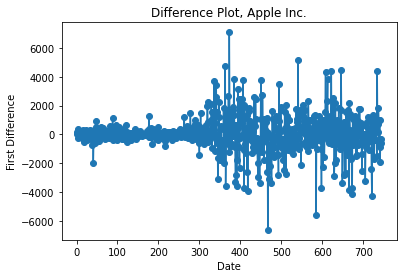

In [36]:
plt.plot(m_df['Diff'], marker='o')

plt.ylabel('First Difference')
plt.xlabel('Date')
plt.title('Difference Plot, Apple Inc.')
plt.show()

In [37]:
result = adfuller(m_df['Diff'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -12.095128624082255,
 'pvalue': 2.0790687422052542e-22,
 'usedlag': 3,
 'nobs': 740,
 'criticalvalues': {'1%': -3.4392177416762086,
  '5%': -2.8654536415414684,
  '10%': -2.5688540485756026},
 'icbest': 12364.285862043018}

By these results, we know we should use the difference to find the lag value (pvalue < 0.05)

C:\Users\buxto\anaconda3\envs\powerbi\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


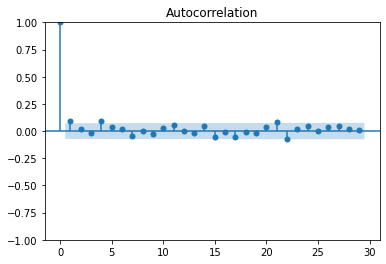

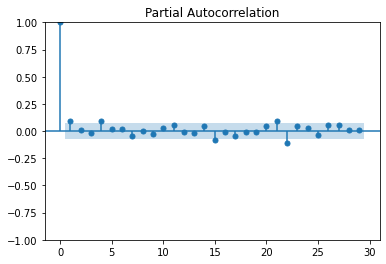

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(m_df['Diff'].dropna())
fig2=plot_pacf(m_df['Diff'].dropna())

The results from this ACF and PACF plot show interesting results. Beyond order = 0, there are not many order values that contribute significantly to prediction.

Training/Test Split

We split our data up in order to make predictions on known data and check the accuracy of our model.

In [39]:
ar_train_data = m_df.iloc[:-15]
ar_test_data = m_df.iloc[-15:]

I stuck with lag = 1 for this AR model

In [40]:
# seems lag should be 1 - test various values?
from statsmodels.tsa.ar_model import AutoReg as ar
res = ar(endog = ar_train_data['High'], lags = 1).fit()

In [41]:
new_dates=[m_df.index[-1]+x for x in range(1, 11)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)

In [42]:
ar_df = pd.concat([m_df, df_pred])

In [43]:
# start at the end of original data, go til the end of this new dataframe
ar_df['predictions']=res.predict(start=ar_train_data.shape[0],end=ar_df.shape[0])

<AxesSubplot:>

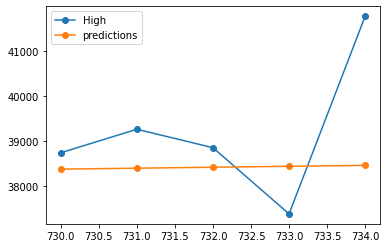

In [44]:
# High contrast plot of price versus predictions for future highs
plot_df = ar_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

Model results in pretty poor accuracy much like the stock data, would be understandable here given the greater degree of volatility compared to the stock data

In [45]:
# export model for dashboard
from joblib import dump
dump(res, 'crautoreg.model')

['crautoreg.model']

### ARIMA Model Creation

It appears from autocorrelation and part. autocorrelation plots that the values for p and q should be 1. d should also be 1 since we took the first difference to uncover the p and q values.

We will use the auto_arima function to grid search for the hyperparameters

In [46]:
from pmdarima import auto_arima
auto_fit = auto_arima(ar_train_data['High'], max_p = 10, d = 1, trace=True, suppress_warnings=True, stepwise=False, max_order=15)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=12447.441, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=12442.725, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=12444.458, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=12444.924, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=12441.992, Time=0.13 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=12441.708, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=12442.542, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=12444.542, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=12442.485, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=12444.211, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=12442.294, Time=0.32 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=12443.667, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=12444.527, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=12443.102, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=12430.530, Time=0.73

In [47]:
from statsmodels.tsa.arima.model import ARIMA
arima_mdl = ARIMA(endog=ar_train_data['High'], order=(2,1,2)).fit()

In [48]:
arima_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  730
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6209.473
Date:                Thu, 17 Feb 2022   AIC                          12428.946
Time:                        10:43:21   BIC                          12451.905
Sample:                             0   HQIC                         12437.805
                                - 730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6611      0.024    -27.879      0.000      -0.708      -0.615
ar.L2         -0.8951      0.027    -33.010      0.000      -0.948      -0.842
ma.L1          0.7358      0.016     46.687      0.000       0.705       0.767
ma.L2          0.9584      0.017     55.966      0.000       0.925       0.992
sigma2      1.518e+06   5.01e+04     30.293      0.000    1.42e+06    1.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               697.41
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              24.31   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

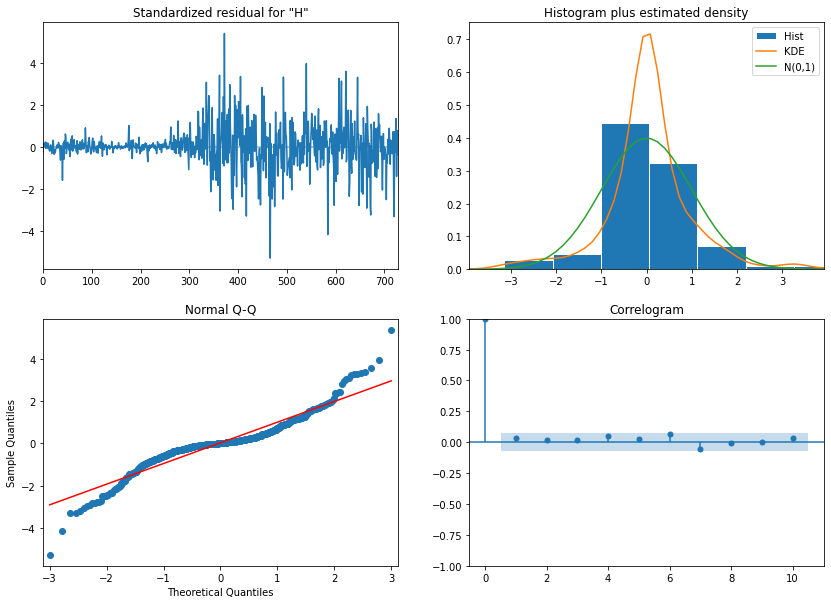

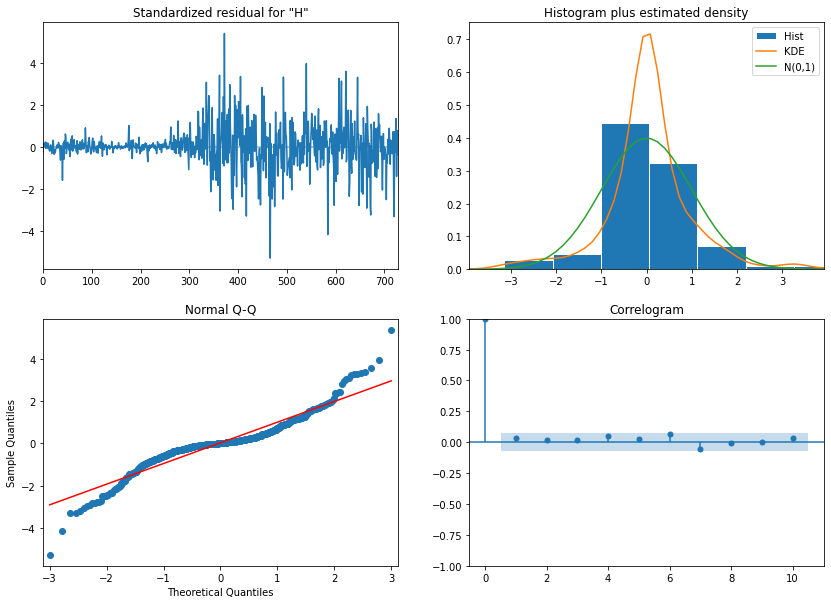

In [49]:
arima_mdl.plot_diagnostics(figsize = (14, 10))

In [50]:
new_dates=[m_df.index[-1]+x for x in range(1, 11)]
df_pred=pd.DataFrame(index=new_dates,columns =m_df.columns)
arima_df = pd.concat([m_df, df_pred])
arima_df['predictions']=arima_mdl.predict(start=ar_train_data.shape[0],end=arima_df.shape[0])

<AxesSubplot:>

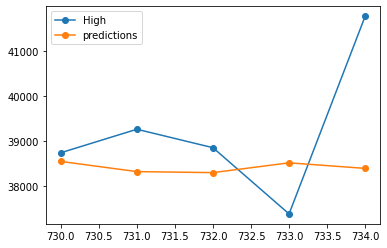

In [51]:
plot_df = arima_df.iloc[ar_train_data.shape[0]:ar_train_data.shape[0]+5]
plot_df[['High', 'predictions']].plot(marker='o')

There is at least some level of movement in this result and the first prediction is nearly spot on - a better result than most of the other models

In [52]:
dump(arima_mdl, 'crarima.model')

['crarima.model']